![alt text](http://media5.datahacker.rs/2018/06/logo-crno.png)

[](https://)[datahacker.rs](http://datahacker.rs)

In [0]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

#import helper
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
# Define transform to normalize data
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])



# Download and load the training data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)


Extracting DATA_MNIST/MNIST/raw/train-images-idx3-ubyte.gz to DATA_MNIST/MNIST/raw



Extracting DATA_MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to DATA_MNIST/MNIST/raw



Extracting DATA_MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to DATA_MNIST/MNIST/raw



Extracting DATA_MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to DATA_MNIST/MNIST/raw
Processing...
Done!


In [0]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype 
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


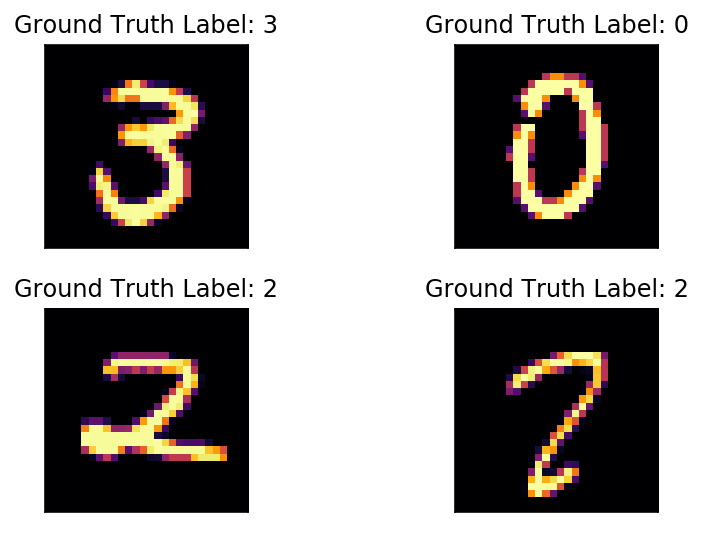

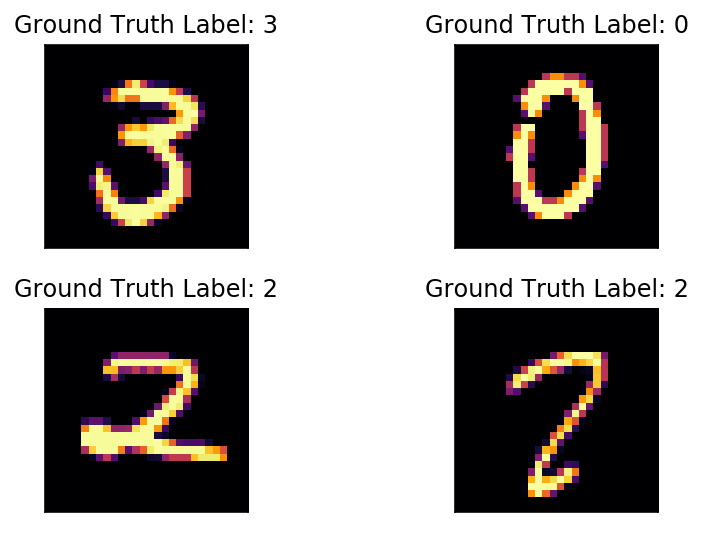

In [12]:
fig = plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap='inferno')
    plt.title("Ground Truth Label: {}".format(labels[i]))
    plt.yticks([])
    plt.xticks([])
fig

In [0]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        # Convolutional Neural Network Layer 
        self.convolutaional_neural_network_layers = nn.Sequential(
                # Here we are defining our 2D convolutional layers
                # We can calculate the output size of each convolutional layer using the following formular
                # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
                # We have in_channels=1 because our input is a grayscale image
                nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28) 
                nn.ReLU(),
                # After the first convolutional layer the output of this layer is:
                # [(28 + 2*1 - 3)/1] + 1 = 28. 
                nn.MaxPool2d(kernel_size=2), 
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 28 / 2 = 14
          
                # output of our second conv layer
                nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                # After the second convolutional layer the output of this layer is:
                # [(14 + 2*1 - 3)/1] + 1 = 14. 
                nn.MaxPool2d(kernel_size=2) 
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 14 / 2 = 7
        )

        # Linear layer
        self.linear_layers = nn.Sequential(
                # We have the output_channel=24 of our second conv layer, and 7*7 is derived by the formular 
                # which is the output of each convolutional layer
                nn.Linear(in_features=24*7*7, out_features=64),          
                nn.ReLU(),
                nn.Dropout(p=0.2), # Dropout with probability of 0.2 to avoid overfitting
                nn.Linear(in_features=64, out_features=10) # The output is 10 which should match the size of our class
        )

    # Defining the forward pass 
    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        # After we get the output of our convolutional layer we must flatten it or rearrange the output into a vector
        x = x.view(x.size(0), -1)
        # Then pass it through the linear layer
        x = self.linear_layers(x)
        # The softmax function returns the prob likelihood of getting the input image. 
        # We will see a much graphical demonstration below
        x = F.log_softmax(x, dim=1)
        return x

In [0]:
model = Network()
model.to(device)
print(model)

Network(
  (convolutaional_neural_network_layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1176, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [0]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [8]:
epochs = 10 # The total number of iterations

train_losses = []
test_losses = []

for epoch in range(epochs):
    # prep model for training
    model.train()
    train_loss = 0

    for idx, (images, labels) in enumerate(trainloader): 

        # Send these >>> To GPU
        images = images.to(device)
        labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()

        # Forward pass
        output = model(images)
        loss = criterion(output, labels)

        #Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    else:
        # prep model for evaluation
        model.eval() 
        test_loss = 0
        accuracy = 0

        # Turn off the gradients when performing validation.
        # If we don't turn it off, we will comprise our networks weight entirely
        with torch.no_grad():
            for images, labels in testloader:
                
                images = images.to(device)
                labels = labels.to(device)
                
                log_probabilities = model(images)
                test_loss += criterion(log_probabilities, labels)

                probabilities = torch.exp(log_probabilities)
                top_prob, top_class = probabilities.topk(1, dim=1)
                predictions = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(predictions.type(torch.FloatTensor))
        
        train_losses.append(train_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}  ".format(epoch+1, epochs),
              "Training loss: {:.4f}  ".format(train_loss/len(trainloader)),
              "Testing loss: {:.4f}  ".format(test_loss/len(testloader)),
              "Test accuracy: {:.4f}  ".format(accuracy/len(testloader)))

Epoch: 1/10   Training loss: 0.6982   Testing loss: 0.2648   Test accuracy: 0.9243  
Epoch: 2/10   Training loss: 0.2395   Testing loss: 0.1460   Test accuracy: 0.9536  
Epoch: 3/10   Training loss: 0.1677   Testing loss: 0.1251   Test accuracy: 0.9602  
Epoch: 4/10   Training loss: 0.1314   Testing loss: 0.0903   Test accuracy: 0.9707  
Epoch: 5/10   Training loss: 0.1115   Testing loss: 0.0715   Test accuracy: 0.9762  
Epoch: 6/10   Training loss: 0.0940   Testing loss: 0.0661   Test accuracy: 0.9772  
Epoch: 7/10   Training loss: 0.0844   Testing loss: 0.0572   Test accuracy: 0.9805  
Epoch: 8/10   Training loss: 0.0777   Testing loss: 0.0589   Test accuracy: 0.9803  
Epoch: 9/10   Training loss: 0.0714   Testing loss: 0.0577   Test accuracy: 0.9812  
Epoch: 10/10   Training loss: 0.0677   Testing loss: 0.0474   Test accuracy: 0.9845  


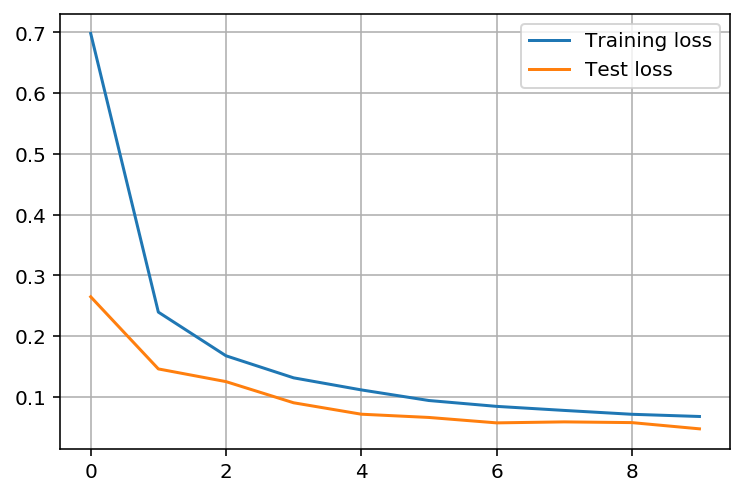

In [9]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.grid()

In [10]:
img = images[0]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

# Since we want to use the already pretrained weights to make some prediction
# we are turning off the gradients
with torch.no_grad():
    logits = model.forward(img)

torch.Size([1, 1, 28, 28])


[2.1293199e-10 2.5803686e-09 2.8972769e-09 9.9993694e-01 3.7128189e-13
 1.7887916e-05 4.2800134e-12 2.3694324e-10 1.4829320e-05 3.0359324e-05]


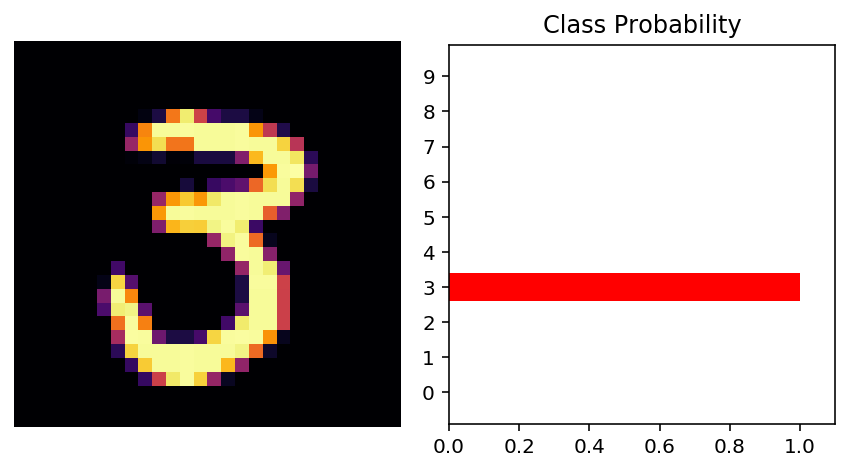

In [11]:
# We take the softmax for probabilites since our outputs are logits
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()